In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-30_22-01_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.04535031847133758

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
YM       0.25
GC       0.25
NQ       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    16683.70
GC     8850.04
NQ    32718.00
YM    25340.20
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

83591.94

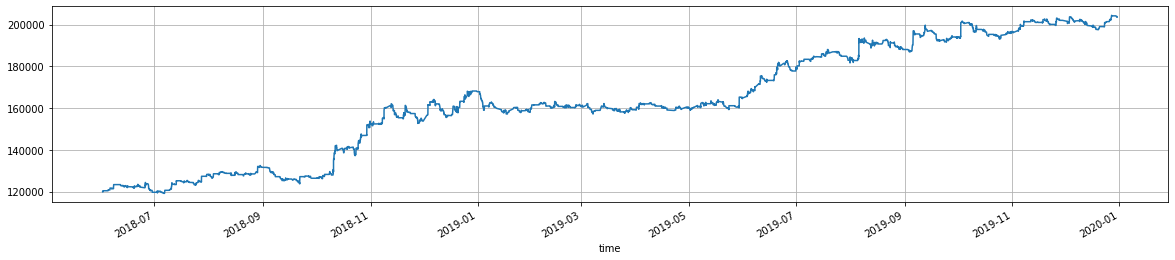

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     478
 GC     939
 NQ    1970
 YM     538
 Name: action, dtype: int64,
 3925)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.160194
 GC    2.279126
 NQ    4.781553
 YM    1.305825
 Name: action, dtype: float64,
 9.526699029126213)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1003.80
GC    2272.38
NQ    4137.00
YM    1129.80
Name: commission, dtype: float64

In [16]:
df.commission.sum()

8542.980000000001

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.38,18.87,468.46,-258.63,1.81,17.66,469.0
NQ,0.40,33.22,452.50,-251.07,1.80,30.36,985.0
ES,0.41,69.81,960.49,-538.62,1.78,76.02,239.0
YM,0.42,94.20,736.15,-370.80,1.99,94.12,269.0
total,0.40,42.61,559.47,-303.58,1.84,41.64,1962.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.002637,0.232006,0.513677,0.738312
GC,0.002637,1.000000,0.074992,0.067702,0.364668
NQ,0.232006,0.074992,1.000000,0.239783,0.660353
YM,0.513677,0.067702,0.239783,1.000000,0.722823
total,0.738312,0.364668,0.660353,0.722823,1.000000


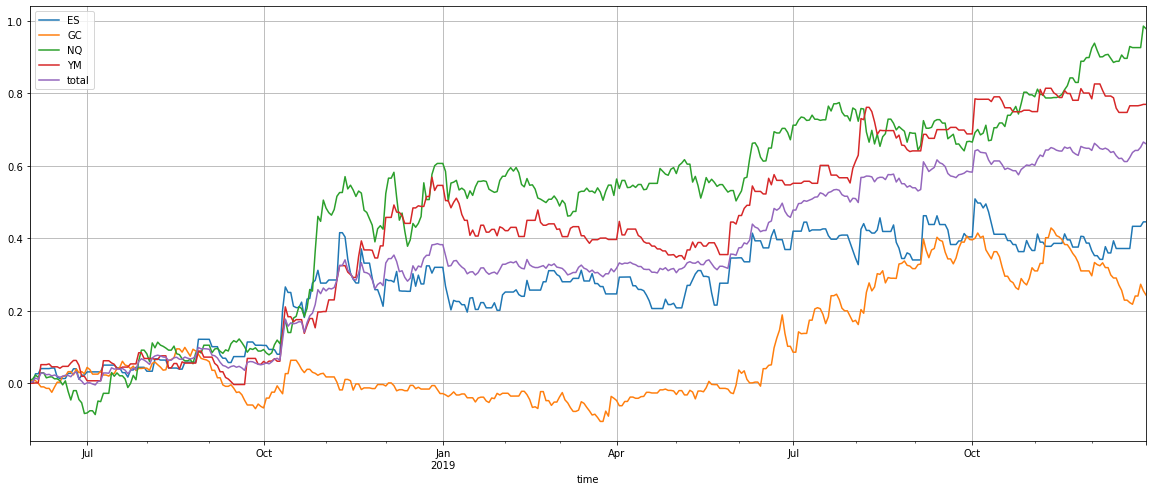

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

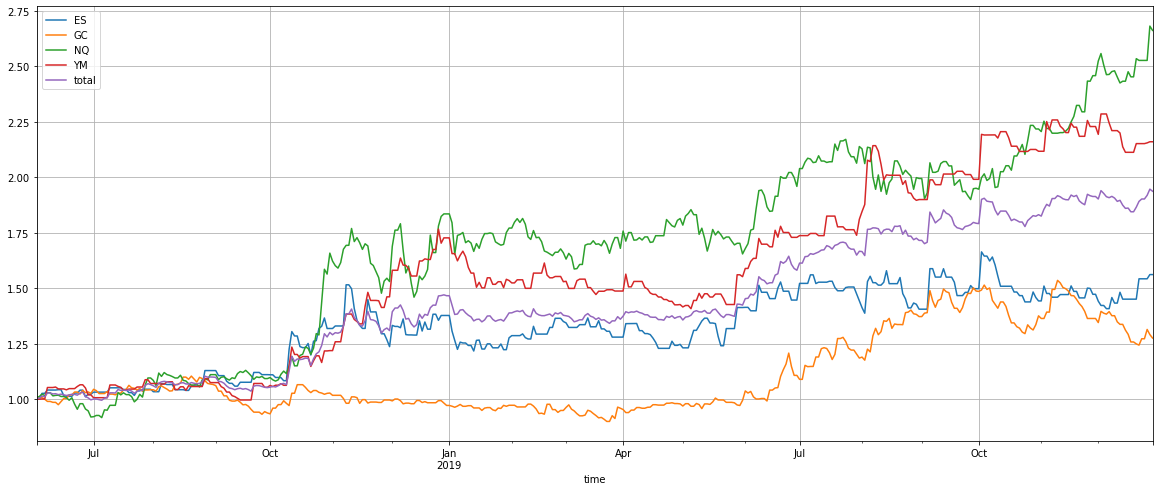

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.313292,0.160434,0.819596,0.601448,0.498235
Cumulative returns,0.561390,0.275408,1.660961,1.159544,0.936686
Annual volatility,0.374013,0.253492,0.371200,0.305497,0.209347
Sharpe ratio,0.909469,0.711808,1.797054,1.691163,2.035260
Calmar ratio,1.591993,0.844622,4.436262,2.961222,5.699694
Stability,0.773581,0.525179,0.869405,0.895209,0.933419
Max drawdown,-0.196792,-0.189947,-0.184749,-0.203108,-0.087414
Omega ratio,1.247393,1.148497,1.406945,1.516708,1.509839
Sortino ratio,1.784069,1.283282,3.129102,3.639618,4.195414
Skew,2.217380,1.328977,0.859639,2.081753,1.979161


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,2.27,2.65,-8.01,1.94,-0.28
2018-07-31,2.18,1.57,19.11,5.04,6.91
2018-08-31,8.03,2.29,1.37,0.38,3.15
2018-09-30,-1.62,-12.04,-1.60,-1.97,-4.30
2018-10-31,18.71,9.57,51.70,15.68,23.60
2018-11-30,-6.20,-3.06,-7.72,19.87,0.66
2018-12-31,11.35,-2.46,19.91,18.17,11.99
2019-01-31,-7.31,0.09,-3.48,-11.11,-5.28
2019-02-28,5.77,-2.40,-6.28,-0.36,-0.77


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        56.0
GC        28.0
NQ       166.0
YM       116.0
total     94.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 15:51:00,ES,SELL,2811.75,4183.3
2018-10-10 21:49:30,ES,BUY,2814.25,3908.3
2019-09-05 19:04:30,ES,SELL,2975.25,3895.8
2019-08-05 20:48:00,ES,BUY,2838.25,3645.8
2019-10-02 21:00:00,ES,BUY,2893.75,3320.8
...,...,...,...,...
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.2
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2
2018-12-26 11:04:00,ES,BUY,2360.75,-1454.2


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-09-05,0.129860,0.071505,0.070387,0.046720,0.079618
2019-08-05,0.102637,0.042344,0.035793,0.106360,0.071784
2018-12-03,0.077360,-0.003989,0.103553,0.081860,0.064696
2019-10-02,0.110693,0.004355,0.026633,0.101693,0.060844
2018-10-11,0.065413,0.057183,0.037633,0.074413,0.058661
...,...,...,...,...,...
2018-10-22,-0.041530,-0.009161,-0.021920,-0.037113,-0.027431
2018-11-13,-0.059447,0.000011,-0.033367,-0.017613,-0.027604
2018-12-10,-0.051947,0.003172,-0.061173,-0.000780,-0.027682
